## **Importing Independences**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zollycitraprayogi/food-ingredients-image")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/food-ingredients-image


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image


2025-06-03 00:55:26.953679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748912127.145205      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748912127.200861      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Creating a base directory**

In [3]:
# Definisi Data yang Dipilih dan Persiapan Direktori 
print("--- Memulai Proses Augmentasi dan Persiapan Dataset ---")

# Path dataset asli
base_dir = '/kaggle/input/food-ingredients-image/Bahan'

# Direktori baru untuk menyimpan hanya salinan data asli yang dipilih
data_select_dir = '/kaggle/working/food-ingredients-image/Data_Select'

# Direktori baru untuk menyimpan hanya gambar hasil augmentasi
augmented_data_dir = '/kaggle/working/food-ingredients-image/Data_Augmented/'

# Definisi kelas dan jumlah gambar asli (ini akan digunakan untuk seleksi)
selected_classes_initial = {
    'Bawang Bombai',
    'Bawang Putih',
    'Ikan',
    'Jagung',
    'Jahe',
    'Kacang Hijau',
    'Kembang Kol',
    'Kentang',
    'Kikil',
    'Kol',
    'Labu Siam',
    'Nasi',
    'Petai',
    'Sawi',
    'Seledri',
    'Telur Ayam',
    'Telur Bebek',
    'Timun',
    'Tomat',
    'Usus',
    'Wortel',
    # data under 150:
    'Bawang Merah',
    'Brokoli',
    'Cabai Hijau',
    'Cabai Merah',
    'Daging Sapi',
    'Daging Unggas',
    'Jamur',
    'Kacang Merah',
    'Kacang Panjang',
    'Kacang Tanah',
    'Mie',
    'Selada',
    'Tempe',
    'Terong'
}

# Target jumlah gambar per kelas setelah augmentasi (total dari Data_Select + Data_Augmented)
TARGET_IMAGES_PER_CLASS = 500

# Hapus direktori 'Data_Select', 'Data_Augmented', dan 'split' jika sudah ada
if os.path.exists(data_select_dir):
    shutil.rmtree(data_select_dir)
os.makedirs(data_select_dir, exist_ok=True)

if os.path.exists(augmented_data_dir):
    shutil.rmtree(augmented_data_dir)
os.makedirs(augmented_data_dir, exist_ok=True)

# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(data_dir):
    class_counts = {}
    if not os.path.exists(data_dir):
        return {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

--- Memulai Proses Augmentasi dan Persiapan Dataset ---


## **Menyalin Data**


--- Menyalin Data Asli yang Dipilih ke 'Data_Select' ---
Menyalin kelas 'Telur Ayam' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Daging Sapi' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Kacang Hijau' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Selada' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Terong' ke '/kaggle/working/food-ingredients-image/Data_Select'.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Menyalin kelas 'Kacang Panjang' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Seledri' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Telur Bebek' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Kacang Tanah' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Mie' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Bawang Bombai' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Brokoli' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Petai' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Kol' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Tomat' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Jahe' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menyalin kelas 'Cabai Hijau' ke '/kaggle/working/food-ingredients-image/Data_Select'.
Menya

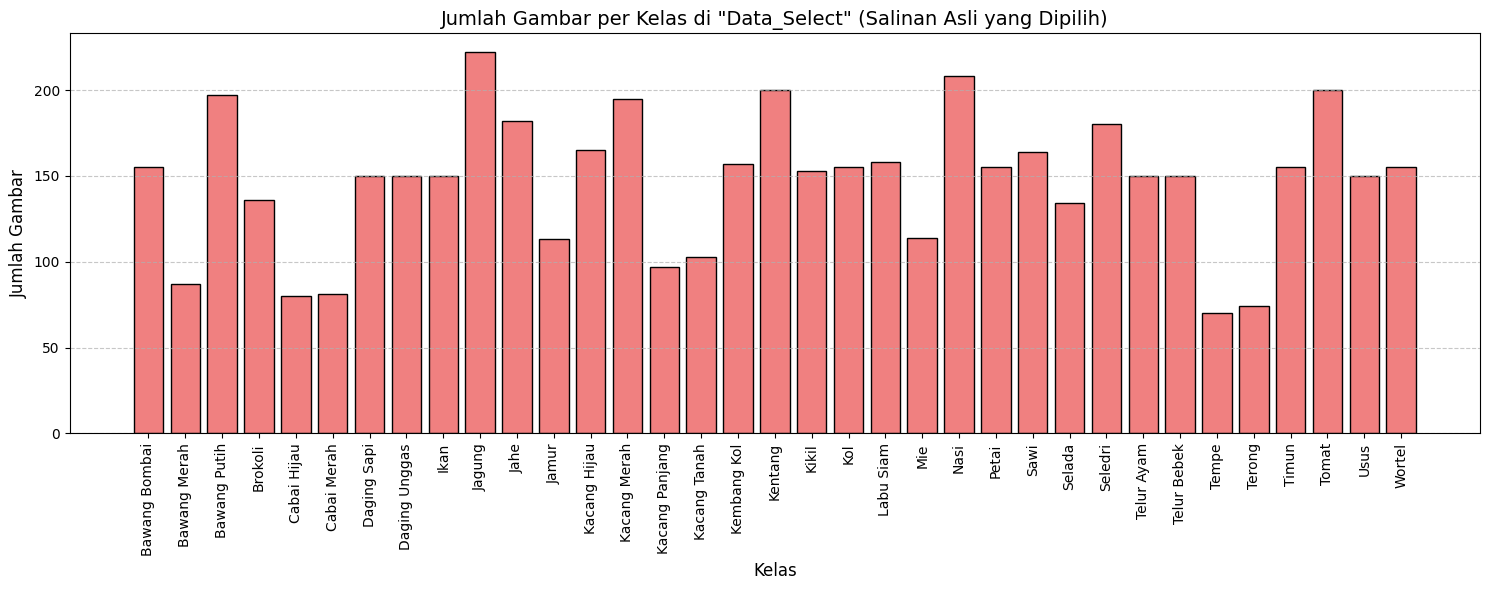

In [4]:
# Menyalin Data Asli yang Dipilih ke 'Data_Select' 
print("\n--- Menyalin Data Asli yang Dipilih ke 'Data_Select' ---")
corrupted_files_copy = []

for class_name in selected_classes_initial:
    original_class_path = os.path.join(base_dir, class_name)
    target_class_path = os.path.join(data_select_dir, class_name)
    os.makedirs(target_class_path, exist_ok=True)

    print(f"Menyalin kelas '{class_name}' ke '{data_select_dir}'.")
    for img_name in os.listdir(original_class_path):
        src_path = os.path.join(original_class_path, img_name)
        try:
            img = Image.open(src_path).convert('RGB')
            dst_path = os.path.join(target_class_path, img_name)
            img.save(dst_path)
        except (OSError, IOError, Image.UnidentifiedImageError) as e:
            print(f"Error processing {src_path} during copy: {e}")
            corrupted_files_copy.append(src_path)
            continue

if corrupted_files_copy:
    print("\nFile bermasalah saat penyalinan (tidak disalin):")
    for file in corrupted_files_copy:
        print(file)

print("\nPenyalinan data asli ke 'Data_Select' selesai.")

# Hitung jumlah gambar di Data_Select setelah penyalinan
class_counts_in_data_select = count_images_per_class(data_select_dir)
print("\n--- Jumlah Gambar di 'Data_Select' (Salinan Asli) ---")
print(class_counts_in_data_select)

# Siapkan data untuk visualisasi: Grafik batang jumlah gambar asli di Data_Select
all_classes_in_data_select = sorted(class_counts_in_data_select.keys())
values_in_data_select = [class_counts_in_data_select.get(cls, 0) for cls in all_classes_in_data_select]

plt.figure(figsize=(15, 6))
plt.bar(all_classes_in_data_select, values_in_data_select, color='lightcoral', edgecolor='black')
plt.title('Jumlah Gambar per Kelas di "Data_Select" (Salinan Asli yang Dipilih)', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## **Visualisasi Data**

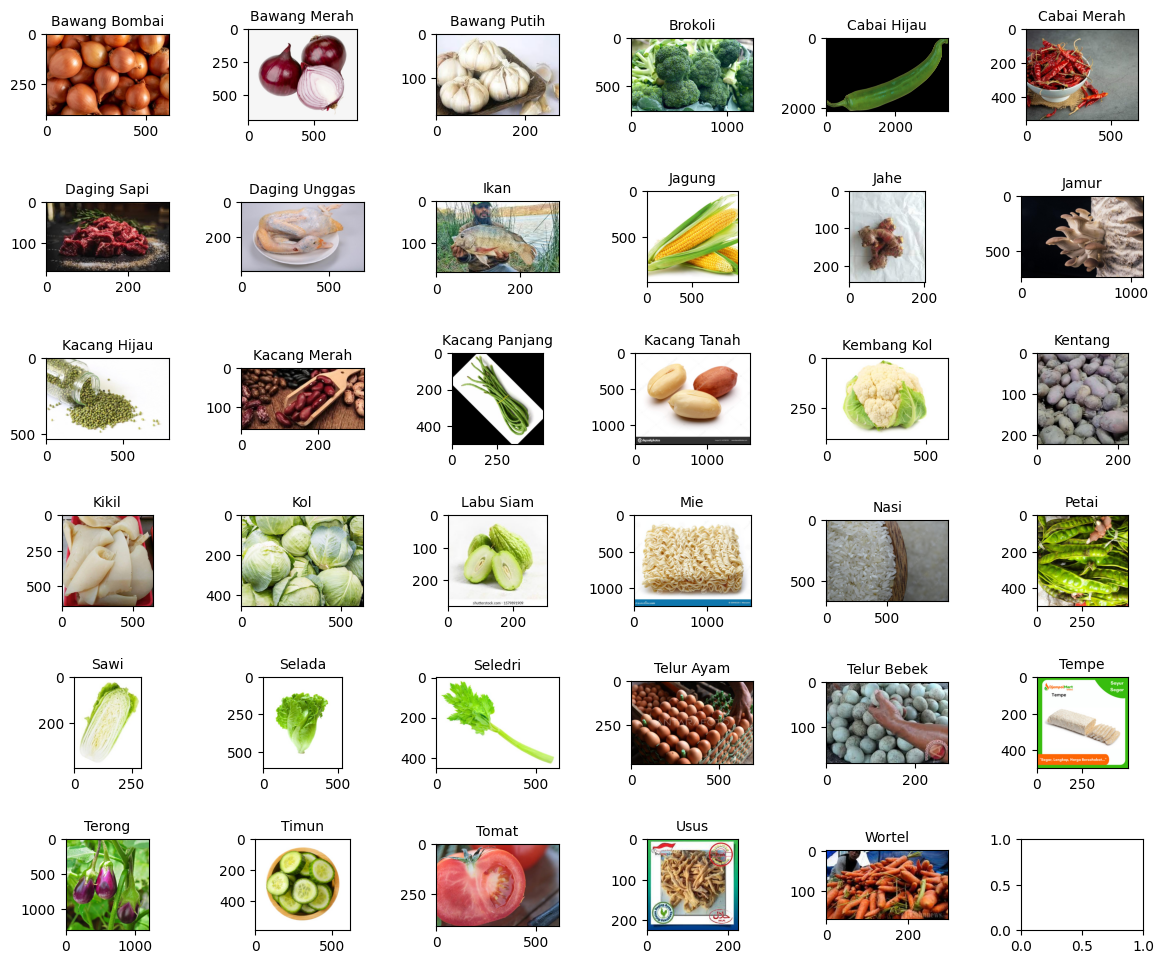

In [5]:
categories = sorted(os.listdir(data_select_dir))

# Initialize list for sample images
sample_images = []
for category in categories:
    category_path = os.path.join(data_select_dir, category)
    first_image = os.listdir(category_path)[0]
    sample_images.append(os.path.join(category_path, first_image))

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))

for ax, img_path, label in zip(axes.flat, sample_images, categories):
    ax.imshow(plt.imread(img_path))  # Display the image
    ax.set_title(label, fontsize=10)  # title for each image

plt.tight_layout(pad=2)
plt.show()

## **Augmentasi Data**

In [6]:
# Melakukan Augmentasi dan Menyimpan ke 'Data_Augmented' 
print("\n--- Memulai Proses Augmentasi dan Menyimpan ke 'Data_Augmented' ---")

# Fungsi augmentasi menggunakan TensorFlow
def augment_image(image):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.clip_by_value(image, 0.0, 255.0)
    return image.numpy().astype(np.uint8)

corrupted_files_augmentation = []

for class_name, original_count in class_counts_in_data_select.items():
    source_class_path = os.path.join(data_select_dir, class_name)
    target_augmented_class_path = os.path.join(augmented_data_dir, class_name)
    os.makedirs(target_augmented_class_path, exist_ok=True) # Pastikan folder kelas di Data_Augmented ada

    num_to_augment = TARGET_IMAGES_PER_CLASS - original_count
    
    if num_to_augment > 0:
        print(f"Mengaugmentasi kelas '{class_name}'. Target Total: {TARGET_IMAGES_PER_CLASS} gambar. Asli: {original_count}. Perlu Augmentasi: {num_to_augment} gambar.")
        
        images_for_augmentation = [os.path.join(source_class_path, img) for img in os.listdir(source_class_path) if not img.startswith('aug_')]
        
        if not images_for_augmentation:
            print(f"Peringatan: Tidak ada gambar asli yang valid di kelas '{class_name}' di Data_Select untuk di-augmentasi.")
            continue

        # Menentukan berapa kali setiap gambar asli perlu di-augmentasi untuk mencapai total
        # Pastikan tidak membuat lebih dari yang dibutuhkan
        augmentation_factor = np.ceil(num_to_augment / len(images_for_augmentation)).astype(int)
        
        aug_idx = 0 # Untuk penomoran gambar augmentasi yang unik
        for img_path in images_for_augmentation:
            if aug_idx >= num_to_augment: # Berhenti jika target augmentasi sudah tercapai
                break
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                
                for i in range(augmentation_factor):
                    if aug_idx >= num_to_augment: # Berhenti jika target augmentasi sudah tercapai
                        break
                    augmented_img = augment_image(img_array)
                    augmented_img_pil = Image.fromarray(augmented_img)
                    
                    original_img_name = os.path.basename(img_path)
                    augmented_img_pil.save(os.path.join(target_augmented_class_path, f'aug_{aug_idx}_{original_img_name}'))
                    aug_idx += 1
            except (OSError, IOError, Image.UnidentifiedImageError) as e:
                print(f"Error processing {img_path} for augmentation in {class_name}: {e}")
                corrupted_files_augmentation.append(img_path)
                continue
    else:
        print(f"Kelas '{class_name}' sudah memiliki {original_count} gambar asli (>= target). Tidak perlu augmentasi tambahan.")

if corrupted_files_augmentation:
    print("\nFile bermasalah saat augmentasi (tidak diproses):")
    for file in corrupted_files_augmentation:
        print(file)

print("\nProses augmentasi selesai. Gambar asli di 'Data_Select', gambar augmentasi di 'Data_Augmented'.")



--- Memulai Proses Augmentasi dan Menyimpan ke 'Data_Augmented' ---
Mengaugmentasi kelas 'Mie'. Target Total: 500 gambar. Asli: 114. Perlu Augmentasi: 386 gambar.


I0000 00:00:1748912255.899721      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Mengaugmentasi kelas 'Jahe'. Target Total: 500 gambar. Asli: 182. Perlu Augmentasi: 318 gambar.
Mengaugmentasi kelas 'Labu Siam'. Target Total: 500 gambar. Asli: 158. Perlu Augmentasi: 342 gambar.
Mengaugmentasi kelas 'Telur Ayam'. Target Total: 500 gambar. Asli: 150. Perlu Augmentasi: 350 gambar.
Mengaugmentasi kelas 'Kacang Panjang'. Target Total: 500 gambar. Asli: 97. Perlu Augmentasi: 403 gambar.
Mengaugmentasi kelas 'Tempe'. Target Total: 500 gambar. Asli: 70. Perlu Augmentasi: 430 gambar.
Mengaugmentasi kelas 'Jamur'. Target Total: 500 gambar. Asli: 113. Perlu Augmentasi: 387 gambar.
Mengaugmentasi kelas 'Timun'. Target Total: 500 gambar. Asli: 155. Perlu Augmentasi: 345 gambar.
Mengaugmentasi kelas 'Tomat'. Target Total: 500 gambar. Asli: 200. Perlu Augmentasi: 300 gambar.
Mengaugmentasi kelas 'Bawang Merah'. Target Total: 500 gambar. Asli: 87. Perlu Augmentasi: 413 gambar.
Mengaugmentasi kelas 'Kol'. Target Total: 500 gambar. Asli: 155. Perlu Augmentasi: 345 gambar.
Mengaugment

## **Cek Data After Augmentation**

In [7]:
# Cek Hasil Data Setelah Augmentasi (Gabungan Virtual) 
# Mengumpulkan semua jalur gambar dan label kelas dari kedua direktori baru untuk visualisasi
all_images_paths_for_viz = []
all_images_labels_for_viz = []

# Dari Data_Select
for class_name in os.listdir(data_select_dir):
    class_path = os.path.join(data_select_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images_paths_for_viz.append(os.path.join(class_path, img_name))
            all_images_labels_for_viz.append(class_name)

# Dari Data_Augmented
for class_name in os.listdir(augmented_data_dir):
    class_path = os.path.join(augmented_data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images_paths_for_viz.append(os.path.join(class_path, img_name))
            all_images_labels_for_viz.append(class_name)



In [8]:
# Membuat dataframe sementara untuk menghitung jumlah gambar per kelas gabungan
df_combined = pd.DataFrame({'path': all_images_paths_for_viz, 'label': all_images_labels_for_viz})
class_counts_after_augmentation_combined = df_combined['label'].value_counts().to_dict()


--- Jumlah Gambar per Kelas (Gabungan Data Asli dan Augmentasi, Target 500) ---
{'Mie': 500, 'Jahe': 500, 'Labu Siam': 500, 'Telur Ayam': 500, 'Kacang Panjang': 500, 'Tempe': 500, 'Jamur': 500, 'Timun': 500, 'Tomat': 500, 'Bawang Merah': 500, 'Kol': 500, 'Kentang': 500, 'Terong': 500, 'Sawi': 500, 'Bawang Bombai': 500, 'Nasi': 500, 'Kembang Kol': 500, 'Daging Unggas': 500, 'Usus': 500, 'Kacang Hijau': 500, 'Jagung': 500, 'Petai': 500, 'Daging Sapi': 500, 'Wortel': 500, 'Seledri': 500, 'Kikil': 500, 'Selada': 500, 'Kacang Tanah': 500, 'Cabai Hijau': 500, 'Cabai Merah': 500, 'Ikan': 500, 'Telur Bebek': 500, 'Kacang Merah': 500, 'Bawang Putih': 500, 'Brokoli': 500}


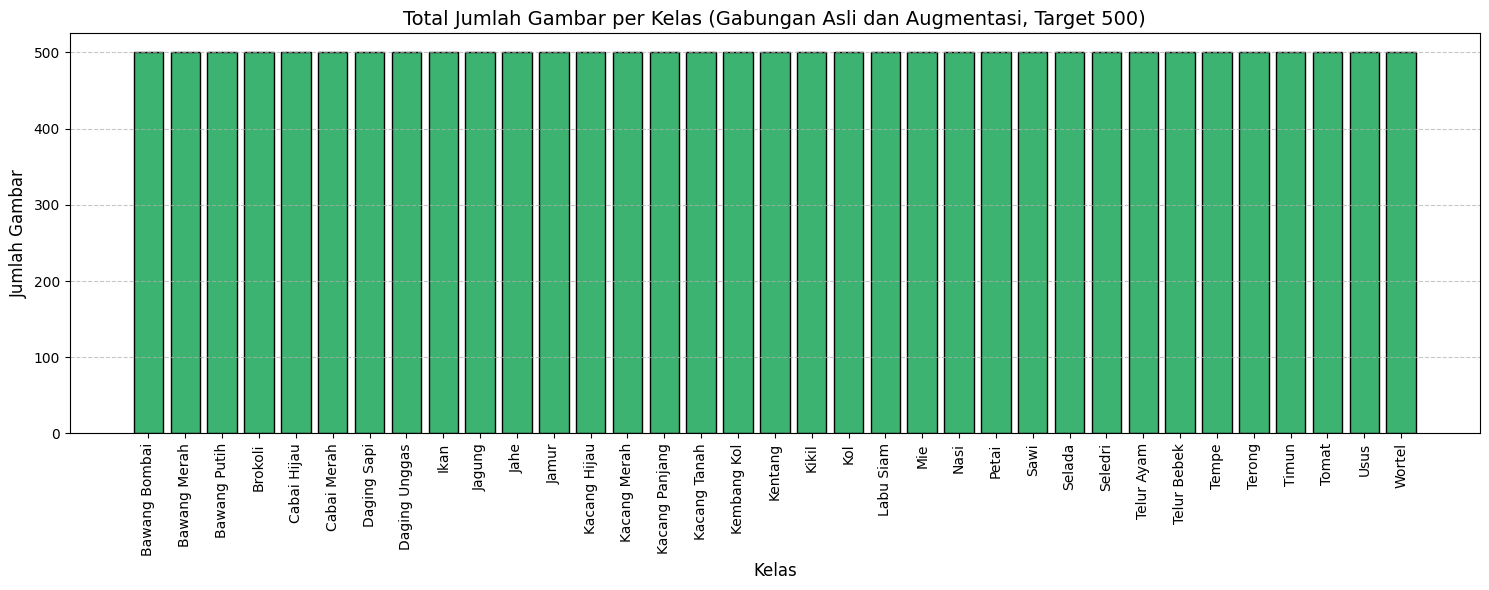

In [9]:
all_classes_after_full_aug_combined = sorted(class_counts_after_augmentation_combined.keys())
values_after_full_aug_combined = [class_counts_after_augmentation_combined.get(cls, 0) for cls in all_classes_after_full_aug_combined]

print("\n--- Jumlah Gambar per Kelas (Gabungan Data Asli dan Augmentasi, Target 500) ---")
print(class_counts_after_augmentation_combined)

plt.figure(figsize=(15, 6))
plt.bar(all_classes_after_full_aug_combined, values_after_full_aug_combined, color='mediumseagreen', edgecolor='black')
plt.title('Total Jumlah Gambar per Kelas (Gabungan Asli dan Augmentasi, Target 500)', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Membagi Dataset Menjadi Train, Test, dan Validation**

In [10]:
# Direktori untuk hasil split
split_base_dir = '/kaggle/working/food-ingredients-image/split'
train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'validation')
test_dir = os.path.join(split_base_dir, 'test')

In [11]:
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [12]:
# Membagi Dataset Menjadi Train, Test, dan Validation dari Data Gabungan 
print("\n--- Memulai Pembagian Dataset (Train, Val, Test) ---")

# Data untuk split sudah dikumpulkan di sebelumnya (all_images_paths_for_viz, all_images_labels_for_viz)

# Memisahkan menjadi train_val (80%) dan test (20%)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    all_images_paths_for_viz, all_images_labels_for_viz, test_size=0.2, random_state=42, stratify=all_images_labels_for_viz
)

# Pisahkan train (70%) dan val (10%) dari train_val (total 80%)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.125, random_state=42, stratify=train_val_labels
)

# Salin ke direktori masing-masing
print("Menyalin gambar ke direktori train, validation, dan test...")
for img_path, label in zip(train_images, train_labels):
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    shutil.copy(img_path, os.path.join(train_dir, label, os.path.basename(img_path)))
for img_path, label in zip(val_images, val_labels):
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    shutil.copy(img_path, os.path.join(val_dir, label, os.path.basename(img_path)))
for img_path, label in zip(test_images, test_labels):
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    shutil.copy(img_path, os.path.join(test_dir, label, os.path.basename(img_path)))

print("\nDataset berhasil dibagi menjadi train (70%), validation (10%), dan test (20%).")
print("--- Proses Selesai Seluruhnya ---")


--- Memulai Pembagian Dataset (Train, Val, Test) ---
Menyalin gambar ke direktori train, validation, dan test...

Dataset berhasil dibagi menjadi train (70%), validation (10%), dan test (20%).
--- Proses Selesai Seluruhnya ---


In [13]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(data_dir):
    class_counts = {}
    if not os.path.exists(data_dir):
        return {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class(train_dir)
val_class_counts = count_images_per_class(val_dir)
test_class_counts = count_images_per_class(test_dir)

print("\n--- Jumlah Gambar per Kelas (Train) ---")
print(train_class_counts)
train_total_count = sum(train_class_counts.values())
print(f"Total gambar di Train: {train_total_count}")


print("\n--- Jumlah Gambar per Kelas (Validation) ---")
print(val_class_counts)
val_total_count = sum(val_class_counts.values())
print(f"Total gambar di Validation: {val_total_count}")


print("\n--- Jumlah Gambar per Kelas (Test) ---")
print(test_class_counts)
test_total_count = sum(test_class_counts.values())
print(f"Total gambar di Test: {test_total_count}")


--- Jumlah Gambar per Kelas (Train) ---
{'Mie': 350, 'Jahe': 350, 'Labu Siam': 350, 'Telur Ayam': 350, 'Kacang Panjang': 350, 'Tempe': 350, 'Jamur': 350, 'Timun': 350, 'Tomat': 350, 'Bawang Merah': 350, 'Kol': 350, 'Kentang': 350, 'Terong': 350, 'Sawi': 350, 'Bawang Bombai': 350, 'Nasi': 350, 'Kembang Kol': 350, 'Daging Unggas': 350, 'Usus': 350, 'Kacang Hijau': 350, 'Jagung': 350, 'Petai': 350, 'Daging Sapi': 350, 'Wortel': 350, 'Seledri': 350, 'Kikil': 350, 'Selada': 350, 'Kacang Tanah': 350, 'Cabai Hijau': 350, 'Cabai Merah': 350, 'Ikan': 350, 'Telur Bebek': 350, 'Kacang Merah': 350, 'Bawang Putih': 350, 'Brokoli': 350}
Total gambar di Train: 12250

--- Jumlah Gambar per Kelas (Validation) ---
{'Mie': 50, 'Jahe': 50, 'Labu Siam': 50, 'Telur Ayam': 50, 'Kacang Panjang': 50, 'Tempe': 50, 'Jamur': 50, 'Timun': 50, 'Tomat': 50, 'Bawang Merah': 50, 'Kol': 50, 'Kentang': 50, 'Terong': 50, 'Sawi': 50, 'Bawang Bombai': 50, 'Nasi': 50, 'Kembang Kol': 50, 'Daging Unggas': 50, 'Usus': 50, 'Ka

## **Pra-Pemrosesan Data Gambar**

In [14]:
# Data augmentation dan normalisasi untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 12245 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.
Found 3500 images belonging to 35 classes.


In [15]:
import shutil
shutil.make_archive('/kaggle/working/food-ingredients-image', 'zip', '/kaggle/working/food-ingredients-image')
print('file data berhasil di zip')

file data berhasil di zip


## **Pembuatan Model CNN**

In [16]:
# Pre-trained model dengan custom CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(35, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │          17,955 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,416,995 (169.44 MB)

 Trainable params: 44,415,523 (169.43 MB)

 Non-trainable params: 1,472 (5.75 KB)

## **Train Model**

In [17]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5),
    ModelCheckpoint('/kaggle/working/model_fix/best_model_pA.h5', save_best_only=True)
]

history1 = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


I0000 00:00:1748912452.440795      59 service.cc:148] XLA service 0x795630003d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748912452.441676      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748912452.834192      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/383 ━━━━━━━━━━━━━━━━━━━━ 1:07:23 11s/step - accuracy: 0.0312 - loss: 5.3973

I0000 00:00:1748912459.156403      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 154s 377ms/step - accuracy: 0.1983 - loss: 3.2979 - val_accuracy: 0.1691 - val_loss: 3.3818 - learning_rate: 0.0010
Epoch 2/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 136s 354ms/step - accuracy: 0.4280 - loss: 1.9698 - val_accuracy: 0.4537 - val_loss: 1.9593 - learning_rate: 0.0010
Epoch 3/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 135s 353ms/step - accuracy: 0.5205 - loss: 1.6212 - val_accuracy: 0.5200 - val_loss: 1.6398 - learning_rate: 0.0010
Epoch 4/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 135s 353ms/step - accuracy: 0.5885 - loss: 1.3746 - val_accuracy: 0.4943 - val_loss: 1.9637 - learning_rate: 0.0010
Epoch 5/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 135s 351ms/step - accuracy: 0.6338 - loss: 1.1873 - val_accuracy: 0.3720 - val_loss: 3.7675 - learning_rate: 0.0010
Epoch 6/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 135s 353ms/step - accuracy: 0.6507 - loss: 1.1266 - val_accuracy: 0.3926 - val_loss: 4.0066 - learning_rate: 0.0010
Epoch 7/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 137s 358ms/step - accuracy: 0.7183 

110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9388 - loss: 0.2115
Test accuracy: 0.9337, Test loss: 0.2312


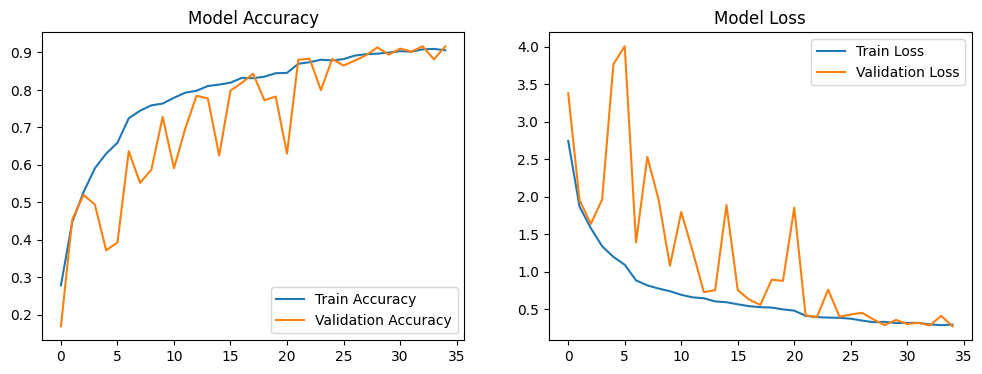

In [18]:
# Evaluasi pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [19]:
model_dir = '/kaggle/working/convert_model1'
os.makedirs(model_dir, exist_ok=True)

# Simpan model .h5
model.save('/kaggle/working/convert_model1/final_model.h5')

# Simpan model ke format SavedModel
model.export('/kaggle/working/convert_model1/SavedModel')
print("Model disimpan dengan format SavedModel!")

# konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/convert_model1/SavedModel')
tflite_model = converter.convert()

# menyimpan file TFLite
with open('/kaggle/working/convert_model1/food_ingredients_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model dikonversi dan disimpan dengan format TF-Lite!")

import shutil
shutil.make_archive('/kaggle/working/convert_model1', 'zip', '/kaggle/working/convert_model1')
print('convert_model1 berhasil di zip')

Saved artifact at '/kaggle/working/convert_model1/SavedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 35), dtype=tf.float32, name=None)
Captures:
  133414372482448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372480144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372481104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372483600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372483024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372480336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372484176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372486288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372485520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133414372486096: TensorSpec(shape=(), dtype=tf.resource, n

W0000 00:00:1748917302.507922      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748917302.507962      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748917302.522615      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Model dikonversi dan disimpan dengan format TF-Lite!
convert_model1 berhasil di zip
